<a href="https://colab.research.google.com/github/pankaj-beldar/Capstone_Project_03_Corona-virus-Tweet-Sentiment-Analysis/blob/main/Capstone_03_Corona_Virus_Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets***

---




# **Problem Description**
This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.
You are given the following information:
1. usename
2. screen name
3. Location
4. Tweet At
5. Original Tweet
6. Sentiment

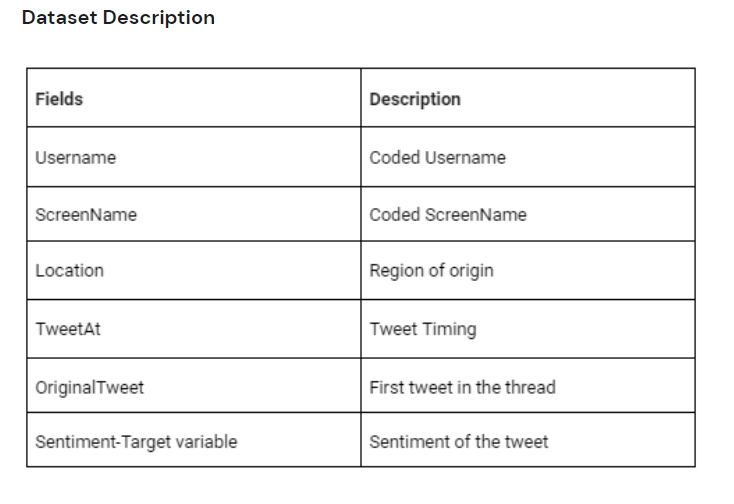

# **Import useful Libraries**

In [12]:
#let's import some useful libraries.
import pandas as pd #for Data Manipulation
import numpy as np # array
from numpy import percentile
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #used to transform a given text into a vector
from tqdm import tqdm # used for creating Progress Meters or Progress Bars
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
!pip install nltk
import nltk
nltk.download('punkt')
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Mounting data on Google Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df= pd.read_csv('/content/Coronavirus Tweets.csv',encoding = 'latin')

In [15]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


# Data Overview

In [16]:
#data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Dataset consists of 41157 entries and 6 attributes. There are no Missing values in all columns except 'Location'. The attribut 'Location' has 8590 missing values. As we want to do sentiment analysis, the 'Location' column is not so important.

# Checking Null Values

In [17]:
df_null= pd.DataFrame(df.isnull().sum())
df_null.reset_index(inplace=True)
df_null

,index,0
0,UserName,0
1,ScreenName,0
2,Location,8590
3,TweetAt,0
4,OriginalTweet,0
5,Sentiment,0


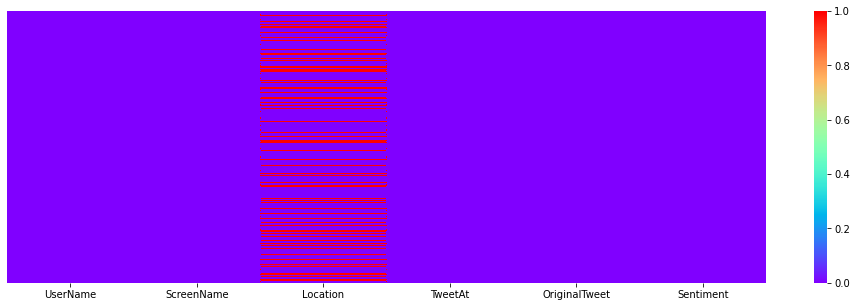

In [18]:
plt.figure(figsize=(17, 5))
sns.heatmap(df.isnull(), cmap='rainbow',cbar=True, yticklabels=False)

Null values are present in 'Location'.  

# Data shape

In [19]:
df.shape

(41157, 6)

The dataset shape is (41157,6)

In [20]:
# Names Of columns in dataset
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

# **Exploratory Data Analysis**

We have try to figure out the following question through Exploratory Data Analysis
1. How many Tweets per day for the given time period?
2. Which are the Top 30 Locations from where maximum tweets were done?
3. What are the Sentiment types and its Distribution?
4. What is the relationship in between number of words, charactors, sentences and different types of Sentiments.
5. What are the most frequent Extremely Positive Sentiment Words?
6. What are the most frequent  Positive Sentiment Words?
7. What are the most frequent Extremely Negative Sentiment Words?
8. What are the most frequent Negative Sentiment Words?
9. What are the most frequent Neutral Sentiment Words?
10. Finding out top 10 most frequent words based on sentiment.

# 1. How many Tweets per day for the given time period?

In [21]:
#Let's check the tweet date 
df_tweetAt=pd.DataFrame(df.TweetAt.value_counts())
df_tweetAt.reset_index(inplace=True)
df_tweetAt.rename(columns={'index':'Date', 'TweetAt':'Tweet_Count'}, inplace=True)
df_tweetAt


,Date,Tweet_Count
0,20-03-2020,3448
1,19-03-2020,3215
2,25-03-2020,2979
3,18-03-2020,2742
4,21-03-2020,2653
5,22-03-2020,2114
6,23-03-2020,2062
7,17-03-2020,1977
8,08-04-2020,1881
9,07-04-2020,1843


We can see ,all tweets are from March and April month.

Text(0.5, 1.0, 'Count Plot of Tweet Date')

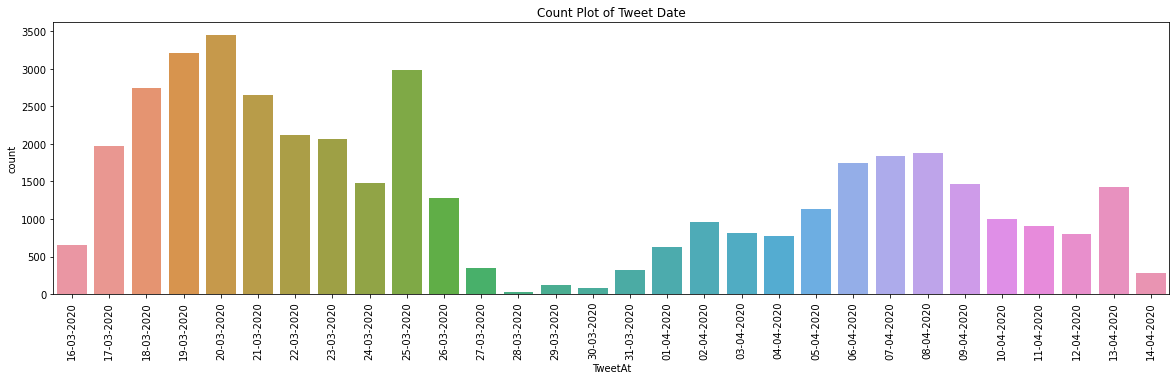

In [22]:
plt.figure(figsize=(20,5))
sns.countplot(x=df["TweetAt"])
plt.xticks(rotation=90)
plt.title('Count Plot of Tweet Date')

Inferences-
1. We can see that maximum tweets were done at 20 march 2020, when first lockdown was declared. People were more active on Tweeter in the month of March because it was the early stage of Corona virus Pandemics and people wanted to know more about this desease. 

# 2. Which are the Top 30 Locations from where maximum tweets were done?

In [23]:
# checking top 30 locations with most of the tweets
Top_30_locations=pd.DataFrame(df.Location.value_counts()[:30])
Top_30_locations.reset_index(inplace=True)
Top_30_locations.rename(columns={'index':'Location', 'Location':'Tweet_Count'}, inplace=True)
Top_30_locations

,Location,Tweet_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


Text(0.5, 1.0, 'Top 30 Locations with most of the tweets')

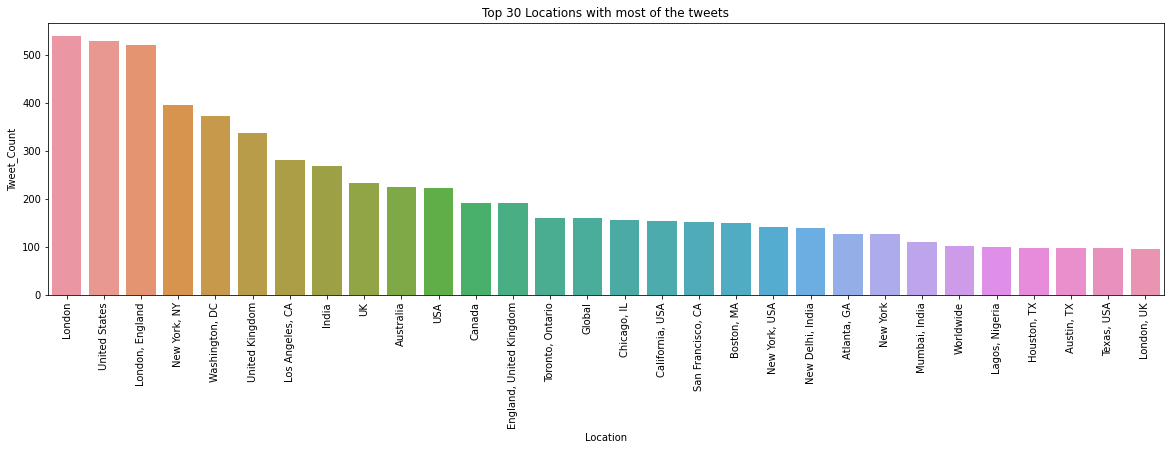

In [24]:
#barplot of top 30 locations with most of the tweets
plt.figure(figsize=(20,5))
sns.barplot(data=Top_30_locations, x='Location', y='Tweet_Count')
plt.xticks(rotation=90)
plt.title('Top 30 Locations with most of the tweets')

Inferences-
1. We can see London, United States, New York, Washington DC, United Kingdom ,India, Australia, USA are the top locations as far as count of tweets are concerned.

# 3. What are the Sentiment types and its Distribution?

In [25]:
# sentiment types for classifications
df_sentiment=pd.DataFrame(df['Sentiment'].value_counts())
df_sentiment.reset_index(inplace=True)
df_sentiment.rename(columns={'index':'Sentiment', 'Sentiment':'Tweet_Count'}, inplace=True)
df_sentiment

,Sentiment,Tweet_Count
0,Positive,11422
1,Negative,9917
2,Neutral,7713
3,Extremely Positive,6624
4,Extremely Negative,5481


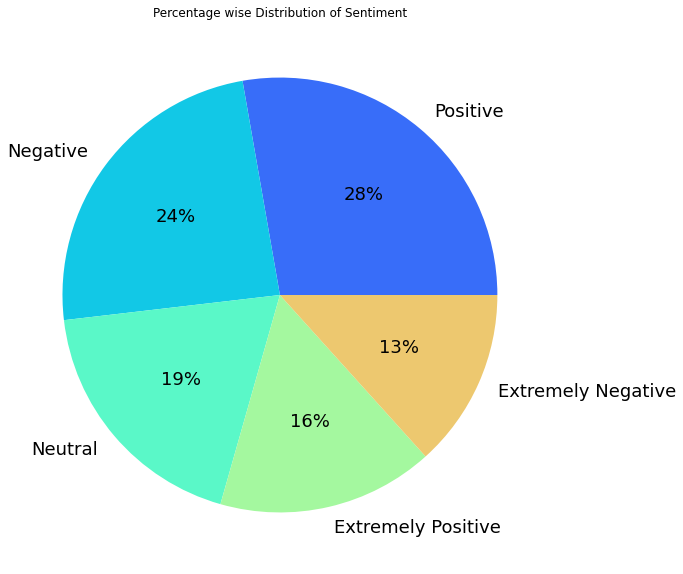

In [26]:
# finding out most frequent sentiment of the people 
plt.figure(figsize=(10,10))
keys = ['Positive','Negative','Neutral','Extremely Positive','Extremely Negative']
  
# define Seaborn color palette to use
palette_color = sns.color_palette('rainbow')
  
# plotting data on chart
plt.pie(df_sentiment['Tweet_Count'], labels=keys, colors=palette_color, autopct='%.0f%%', textprops={'fontsize': 18})
plt.title('Percentage wise Distribution of Sentiment')
# displaying chart
plt.show()


Inferences-
1. We can see, Most of the people (28% ) were having Positive sentiment about covid followed by Negative (24%), Neutral(19%), Extremely Positive (16%) and Extremely Negative(13%).
2. Our Target variable is not Unbalanceed as all Categories are not having much differences between them.

# 4. What is the relationship in between number of words, charactors, sentences and different types of Sentiments.

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
#create a feature Number of charactors in tweet
df['num_char']= df['OriginalTweet'].apply(len)

In [29]:
# num of words
df['num_words'] = df['OriginalTweet'].apply(lambda x:len(nltk.word_tokenize(x)))

In [30]:
# num of Sentences
df['num_sentences'] = df['OriginalTweet'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [31]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1


Text(0.5, 1.0, 'Number of Sentences and Sentiment Relation')

<Figure size 720x360 with 0 Axes>

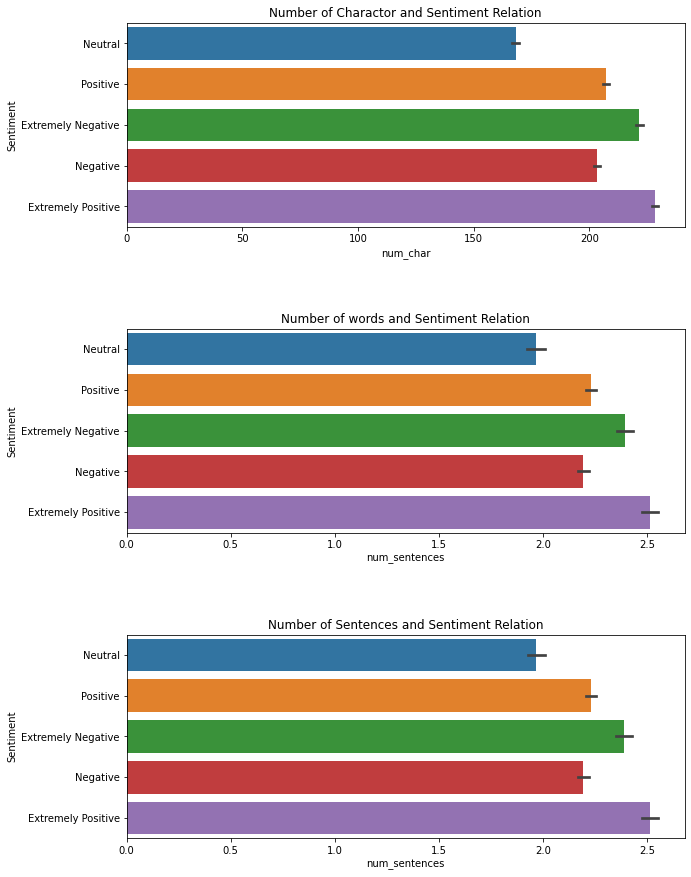

In [32]:
#check relation between sentiment and number of words, charactors and sentences of the tewwt. 
plt.figure(figsize=(10,5))
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,15))
ax = axes.flatten()
sns.barplot(data=df, x='num_char', y='Sentiment', ax=ax[0])
plt.subplots_adjust(hspace=0.5, wspace=0.2)
sns.barplot(data=df, x='num_sentences', y='Sentiment', ax=ax[1])
sns.barplot(data=df, x='num_sentences', y='Sentiment', ax=ax[2])
ax[0].set_title('Number of Charactor and Sentiment Relation')
ax[1].set_title('Number of words and Sentiment Relation')
ax[2].set_title('Number of Sentences and Sentiment Relation')

Inferences-
1. We can see that if the number of words, charactors and sentences are more then sentiment of the tweet is more positive.
2. Neutral Sentiment Tweets consists of less numbers of words, charactors and sentences.

# **Data Preprocessing** 

# Removing @user

In [33]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [34]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P"


# Removing URL and HTML tags

In [35]:
#Removing URL and HTML tags
def remove_url(text):
  pattern =re.compile('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*')
  return pattern.sub(r'',text)

df['Tweet']=df['Tweet'].apply(remove_url)
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"


# Removing Short Words 

In [36]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [37]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,"Coronavirus Australia: Woolworths give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"


# Removing Punctuations 

In [38]:
# Removing Punctuations
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
#function to remove the punctuations from Tweet
def remove_punc(text):
  return text.translate(str.maketrans(' ',' ',string.punctuation))

In [40]:
#apply remove punctuation function to the Tweet column
df['Tweet']=df['Tweet'].apply(remove_punc)
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,Coronavirus Australia Woolworths give elderly disabled dedicated shopping hours amid COVID19 outbreak


# Removing Stop Words 

In [41]:
#downloading NLTK library to find out stop words
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [42]:
#list of stopwords for English
from nltk.corpus import stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [43]:
# Removing Stop words from gensim library
from gensim.parsing.preprocessing import remove_stopwords
df['Tweet']=df['Tweet'].apply(remove_stopwords)
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,Coronavirus Australia Woolworths elderly disabled dedicated shopping hours amid COVID19 outbreak


In [44]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c, e,  , T, l, k,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g, e,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e, e,  , c, n, c,  , l,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, h, b, ...
2                                       [C, r, n, v, r, u,  , A, u, r, l,  , W, l, w, r, h,  , e, l, e, r, l,  , b, l, e,  , e, c, e,  , h, p, p, n, g,  , h, u, r,  ,  , C, O, V, I, D, 1, 9,  , u, b, r, e, k]
3        [f,  , c, k,  , P, L, E, A, S, E,  , n,  , p, n, c,  , T, H, E, R, E,  , W, I, L, L,  , E, N, O, U, G, H,  , F, O, O, D,  , F, O, R,  , E, V, E, R, Y, O, N, E,  , n, e, e,  , S,  , c, l,  ,  , f, ...
4        [M, e,  , r, e,  , u, p, e, r, r, k, e,  , C, O, V, I, D, 1, 9,  , u, b, r, e, k,  , N,  , I,  , p, r, n,  , f,  , c, k,  , l, e, r, l,  , T, h, e,  , c, r

# Spelling Correction

In [45]:
#function for Spelling Check
#from textblob import Word

#def correct_word(text):
    
  #word = Word(text)
 # return word.correct()

#df['Tweet']=df['Tweet'].apply(correct_word)
#df.head()

# Removing Emojies

In [46]:
#function to remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df['Tweet']=df['Tweet'].apply(deEmojify)
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,Coronavirus Australia Woolworths elderly disabled dedicated shopping hours amid COVID19 outbreak


# Convert to Lower Case 

In [47]:
#Convert to lower case using lower() method
df['Tweet']=df['Tweet'].str.lower()
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular meds order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,coronavirus australia woolworths elderly disabled dedicated shopping hours amid covid19 outbreak


# Stemming

Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers.

In [48]:
# import the existing word and sentence tokenizing 
# libraries
#from nltk.tokenize import sent_tokenize, word_tokenize
#df['Tweet']= df['Tweet'].apply(word_tokenize)

# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

In [49]:
#tokenized_tweet = df['Tweet'].apply(lambda x: x.split())
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = df['Tweet'].apply(lambda x: [stemmer.stem(i) for i in x])

In [50]:
#Appply Stemming to Tweet column
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        y.append(stemmer.stem(i))       
    return " ".join(y)

In [51]:
df['Tweet']=df['Tweet'].apply(transform_text)

In [52]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,coronaviru australia woolworth elderli disabl dedic shop hour amid covid19 outbreak
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive,306,58,4,food stock pleas dont panic there will enough food for everyon need stay calm stay safe covid19fr covid19 covid19 coronaviru confin confinementot confinementgener
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative,310,58,4,me readi supermarket covid19 outbreak not im paranoid food stock litterali the coronaviru thing dont panic caus shortag coronavirusfr restezchezv stayathom confin


# Lets Explore WordCloud

Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.

In [53]:
#loading wordCloud
from wordcloud import WordCloud
wc = WordCloud(width=700,height=600,min_font_size=10,background_color='white')

# 5. What are the most frequent Extremely Positive Sentiment Words?

In [54]:
# extremely positive sentiment words
df[df['Sentiment'] == 'Extremely Positive']['Tweet']

11                                                                       due covid19 situat increas demand food product the wait time longer onlin order particularli beef share freezer pack thank patienc time
12                                                                       horningsea care commun letâ all look capabl villag ensur stay healthi bring shop door help onlin shop self isol symptom expos somebodi
18              amazon glitch stymi whole food fresh groceri deliveri âa covid19 spread weâv seen signific increas peopl shop onlin groceriesâ spokeswoman said statement âtoday result system impact affect
22       amaz cheap deal for the covid2019 go help trial monthli yearli and reson price subscript just us bestiptv iptv servic iptv iptvdeal cheap iptv footbal hd movi adult cinema hotmovi iptvnew iptv2020...
23       amaz cheap deal for the covid2019 go help trial monthli yearli and reson price subscript just us bestiptv iptv servic iptv iptvdeal cheap iptv footbal hd m

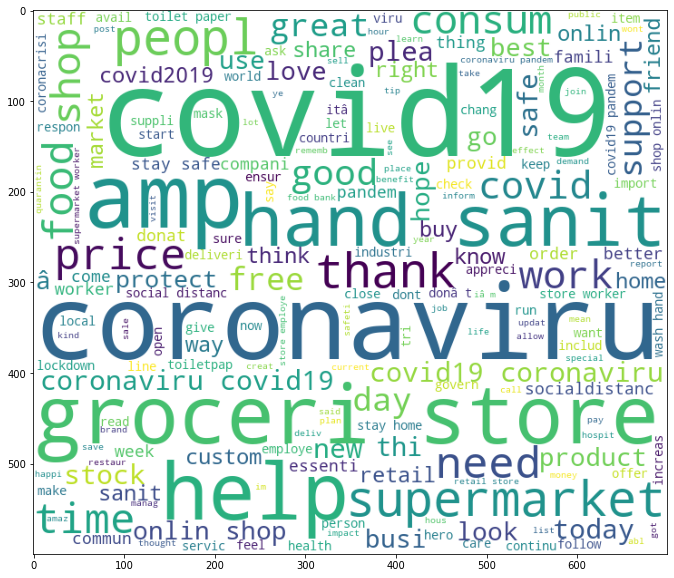

In [55]:
#wordcloud for Extremely Positive Sentiment
extremely_positive_tweet = wc.generate(df[df['Sentiment'] == 'Extremely Positive']['Tweet'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(extremely_positive_tweet)

# 6. What are the most frequent Positive Sentiment  Words?

In [56]:
# positive sentiment words
df[df['Sentiment'] == 'Positive']['Tweet']

1                         advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med order
2                                                                                                                 coronaviru australia woolworth elderli disabl dedic shop hour amid covid19 outbreak
3                                  food stock pleas dont panic there will enough food for everyon need stay calm stay safe covid19fr covid19 covid19 coronaviru confin confinementot confinementgener
5                                                   news regionâ confirm covid19 case came sullivan counti week peopl flock area store purchas clean suppli hand sanit food toilet paper good report
6                                                                                                       cashier groceri store share insight covid19 prove credibl comment im civic class know im talk
          

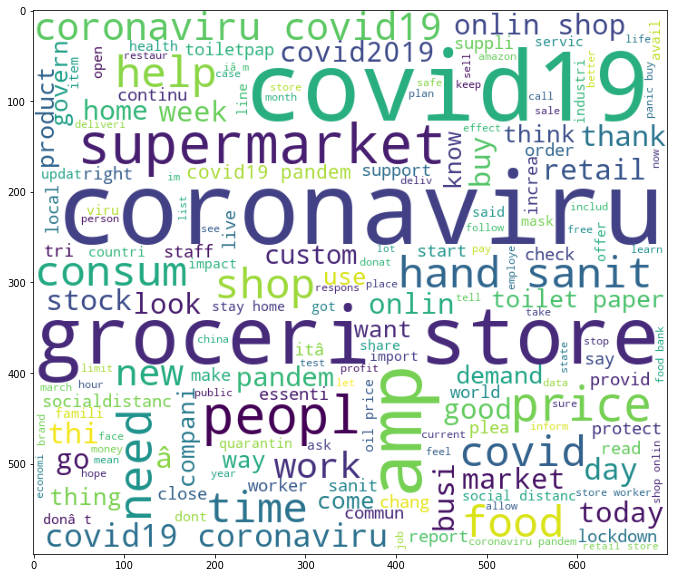

In [57]:
#wordcloud for Positive Sentiment
positive_tweet = wc.generate(df[df['Sentiment'] == 'Positive']['Tweet'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(positive_tweet)

# 7. What are the most frequent Extremely Negative Sentiment Words?

In [58]:
# Negative sentiment words
df[df['Sentiment'] == 'Extremely Negative']['Tweet']

4                                           me readi supermarket covid19 outbreak not im paranoid food stock litterali the coronaviru thing dont panic caus shortag coronavirusfr restezchezv stayathom confin
20                                                         100 nation infict covid world play fair china 100 gover demand china adopt new guild line food safti chines gover guilti irosponc life global scale
27                                                                                         thi morn test posit covid 19 feel ok symptom far isol possibl exposur viru stay home peopl pragmat updat iâm panic
29                                                                               soon dwindl suppli unlaw panicki peopl break close store amp supermarket raid normal crisi massiv coronaviru stockupamplockup
42       check video no food usa market coronaviru panic gon na die starvat coronavirusoutbreak coronaviru houston nofood notoiletpap nohandshak nohandsanit covid19 pandem 

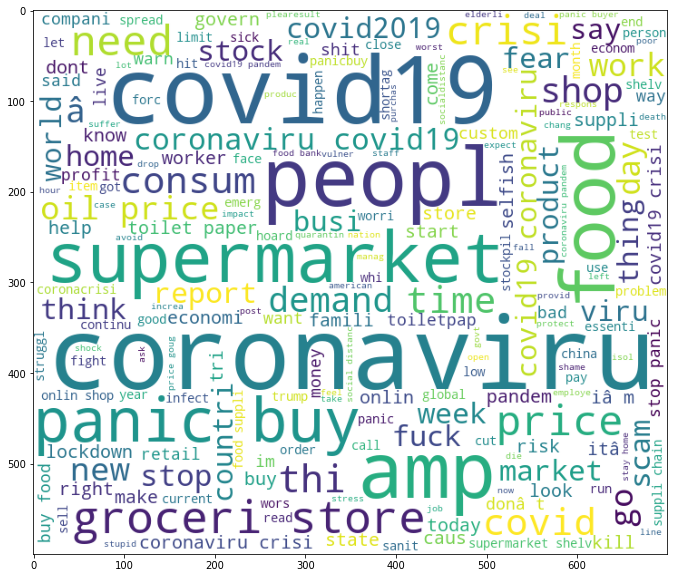

In [59]:
extremely_negative_tweet = wc.generate(df[df['Sentiment'] == 'Extremely Negative']['Tweet'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(extremely_negative_tweet)

# 8. What are the most frequent Negative Sentiment Words?

In [60]:
# Negative sentiment words
df[df['Sentiment'] == 'Negative']['Tweet']

9        for corona preventionw stop buy thing cash use onlin payment method corona spread note also prefer onlin shop home it time fight covid 19 govindia indiafightscorona
24                                                   ensur food essenti product restock supermarket panic buy activ discourag left checkout staff polic action selfish profit
26                                                 prepar higher demand potenti food shortag the hunger coalit purchas percent food implement new protocol covid19 coronaviru
28                   malici price increas nyc the nyc depart consum worker protect dcwp set page digit file complaint click file complaint use wordovercharg covid19 covidnyc
30                                                                                                                          there countri the shelv peopl buy ensu food stock
                                                                                         ...                                      

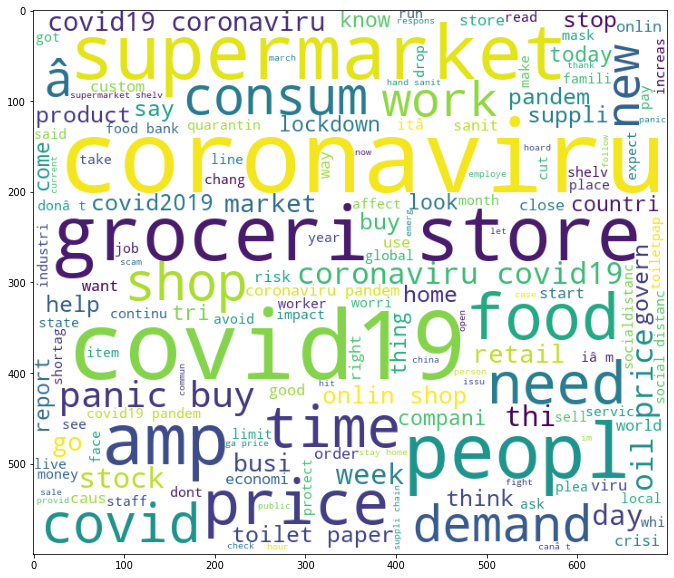

In [61]:
negative_tweet = wc.generate(df[df['Sentiment'] == 'Negative']['Tweet'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(negative_tweet)

# 9. What are the most frequent Neutral Sentiment Words?

In [62]:
# Neutral sentiment words
df[df['Sentiment'] == 'Neutral']['Tweet']

0                                                                                                                                                                                                         
7                                                                                                                               wa supermarket today didnt buy toilet paper rebel toiletpapercrisi covid19
10                                                                     all month crowd supermarket restaur reduc hour close mall mean entranc depend singl supermarket manila lockdown covid2019 philippin
16                                                                                                                                                                                                        
17                                                                                                       16mar20 russia consum surveil watchdog report case high arctic man travel iran covi

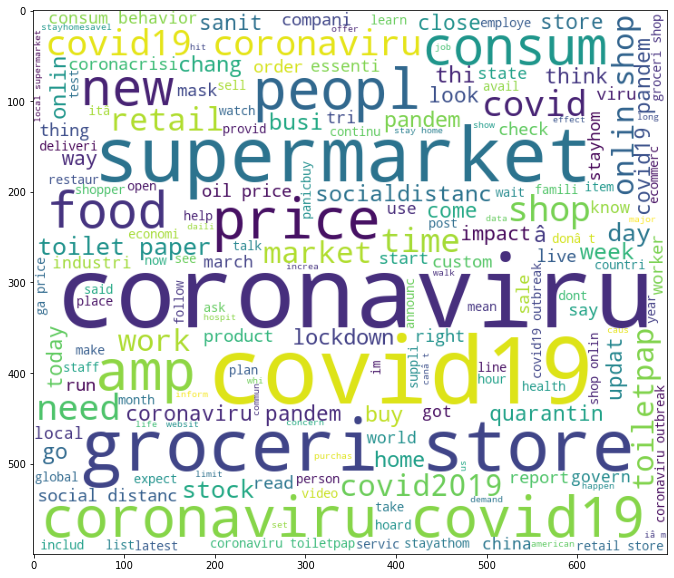

In [63]:
neutral_tweet = wc.generate(df[df['Sentiment'] == 'Neutral']['Tweet'].str.cat(sep=" "))
plt.figure(figsize=(20,10))
plt.imshow(neutral_tweet)

#10.  Finding out Most frequent top 10 words based on the Sentiment

In [64]:
keys = ['Positive','Negative','Neutral','Extremely Positive','Extremely Negative']

Positive 

Number of words in  Positive 196220


<Figure size 432x288 with 0 Axes>

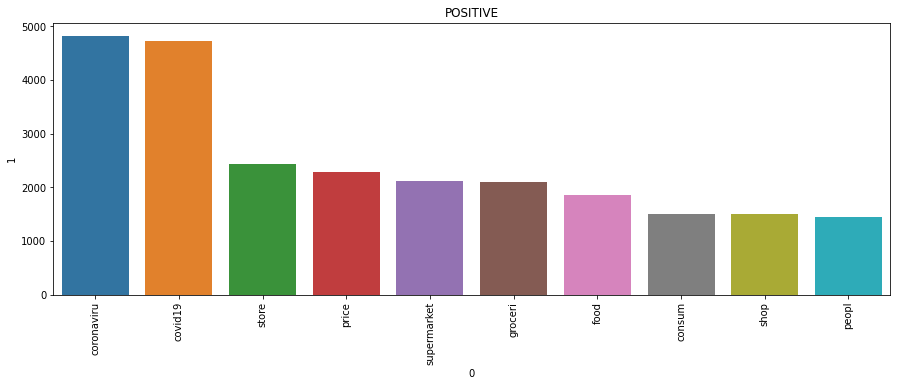

Negative 

Number of words in  Negative 168977


<Figure size 432x288 with 0 Axes>

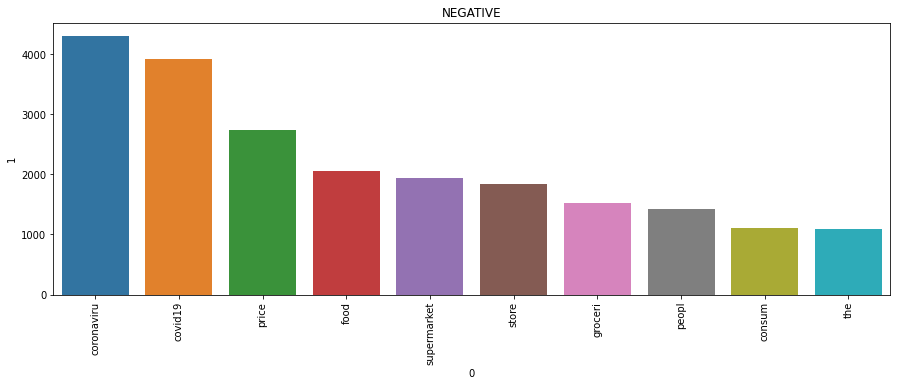

Neutral 

Number of words in  Neutral 102356


<Figure size 432x288 with 0 Axes>

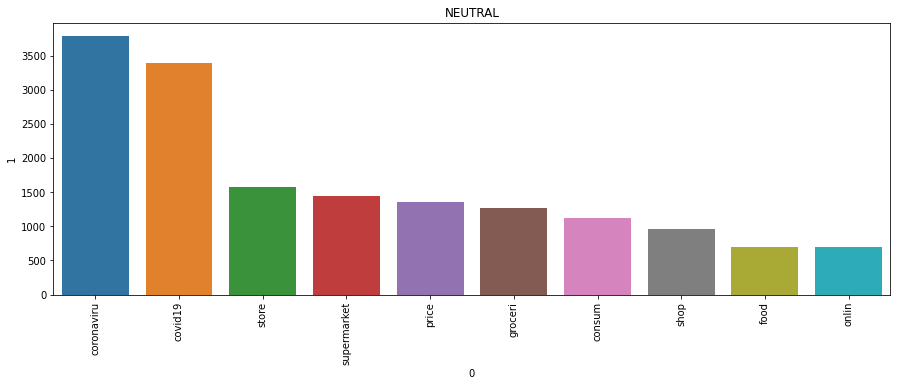

Extremely Positive 

Number of words in  Extremely Positive 127343


<Figure size 432x288 with 0 Axes>

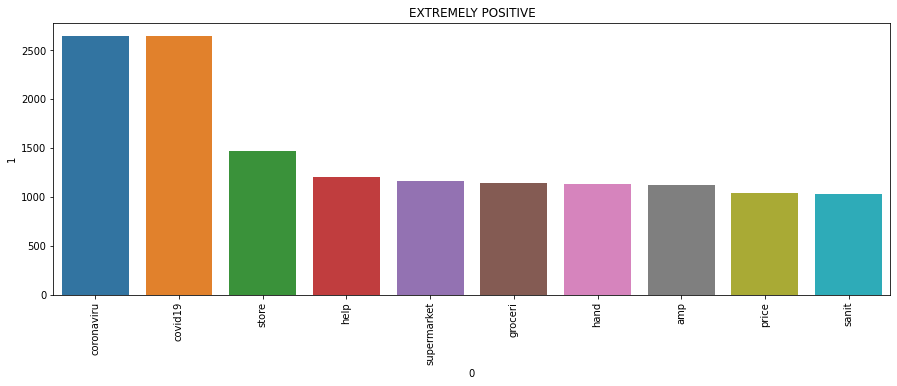

Extremely Negative 

Number of words in  Extremely Negative 105038


<Figure size 432x288 with 0 Axes>

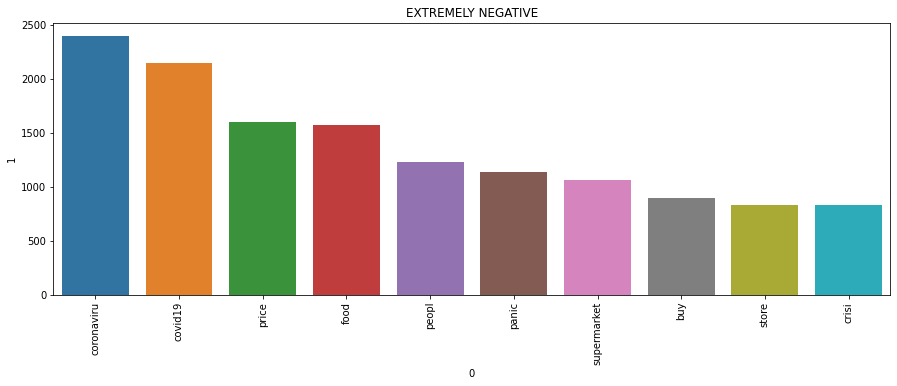

In [65]:
# Finding most frequent words in 'Positive','Negative','Neutral','Extremely Positive','Extremely Negative' sentiment
for n, i in enumerate(keys):
 
 plt.subplots_adjust(hspace=0.5, wspace=0.2)
 
 corpus = []
 for msg in df[df['Sentiment'] == i]['Tweet'].tolist():
    for word in msg.split():
        corpus.append(word)
 print(i,'\n')
 print('Number of words in ',i,len(corpus))  
 from collections import Counter
 plt.figure(figsize=(15,5))
 sns.barplot(pd.DataFrame(Counter(corpus).most_common(10))[0],pd.DataFrame(Counter(corpus).most_common(10))[1])
 plt.xticks(rotation='vertical')
 plt.title(i.upper())
 plt.show()

# **Multiclass Classification Model Development**

# Feature Seletion

In [66]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,num_char,num_words,num_sentences,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,111,17,1,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,237,38,1,advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med order
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,131,18,1,coronaviru australia woolworth elderli disabl dedic shop hour amid covid19 outbreak


In [67]:
# let us find out required attributes for classification model, check number of columns in the dataset.
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'num_char', 'num_words', 'num_sentences', 'Tweet'],
      dtype='object')

Feature Selection-
1. As we want to the sentiment analysis of the tweet, hence 'UserName', 'ScreenName', 'Location', 'TweetAt' are not playing important role for the determination of sentiment of the tweet.
2. Hence we select important features as 'Sentiment', 'num_char', 'num_words', 'num_sentences', 'Tweet' for our analysis.

In [68]:
# Create new dataset with feature selection.
new_df = df[['num_char', 'num_words', 'num_sentences','Tweet','Sentiment']]

In [69]:
new_df.head()

,num_char,num_words,num_sentences,Tweet,Sentiment
0,111,17,1,,Neutral
1,237,38,1,advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med order,Positive
2,131,18,1,coronaviru australia woolworth elderli disabl dedic shop hour amid covid19 outbreak,Positive
3,306,58,4,food stock pleas dont panic there will enough food for everyon need stay calm stay safe covid19fr covid19 covid19 coronaviru confin confinementot confinementgener,Positive
4,310,58,4,me readi supermarket covid19 outbreak not im paranoid food stock litterali the coronaviru thing dont panic caus shortag coronavirusfr restezchezv stayathom confin,Extremely Negative


# Train Test Split

In [70]:
#new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

In [71]:
#Train Test Split
from sklearn.model_selection import train_test_split
train,test = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("test shape : ", test.shape)


train shape :  (32925, 5)
test shape :  (8232, 5)


# Feature Extraction 

# Word Vectorization

Word Embeddings or Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics. 

**TfidfVectorizer** - Transforms text to feature vectors that can be used as input to estimator. vocabulary_ Is a dictionary that converts each token (word) to feature index in the matrix, each unique token gets a feature index.

In [78]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
#vectorizer = CountVectorizer(ngram_range=(1,2),decode_error = 'replace',stop_words = stop,max_features=8000)    #bigram 
#vectorizer = CountVectorizer(ngram_range=(1,3),decode_error = 'replace',stop_words = stop,max_features=8000)    #trigram 
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop,max_features=8000)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_test = vectorizer.transform(test.Tweet.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values

# Classification Model Selection 

#Naive Bayes classifier for multinomial models

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.

training accuracy Score    :  0.6468033409263477
Validation accuracy Score :  0.4870019436345967
classification_report 

                    precision    recall  f1-score   support

Extremely Negative       0.54      0.52      0.53      1151
Extremely Positive       0.52      0.54      0.53      1275
          Negative       0.43      0.44      0.44      1927
           Neutral       0.54      0.55      0.55      1498
          Positive       0.46      0.44      0.45      2381

          accuracy                           0.49      8232
         macro avg       0.50      0.50      0.50      8232
      weighted avg       0.49      0.49      0.49      8232

confusion_matrix 



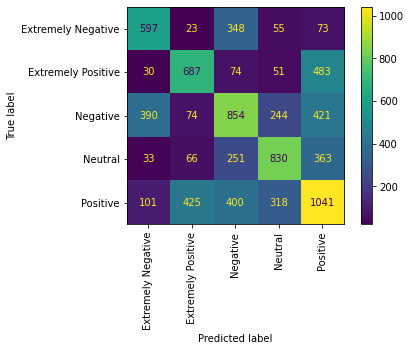

In [79]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)

print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )

print('classification_report','\n')
print(classification_report(NB_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(naiveByes_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()



# SGDClassifier
The class SGDClassifier implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties for classification. Below is the decision boundary of a SGDClassifier trained with the hinge loss, equivalent to a linear SVM.

Training accuracy Score    :  0.774791192103265
Validation accuracy Score :  0.5640184645286687
classification_report 

                    precision    recall  f1-score   support

Extremely Negative       0.69      0.59      0.64      1296
Extremely Positive       0.69      0.64      0.66      1430
          Negative       0.44      0.50      0.47      1767
           Neutral       0.74      0.59      0.66      1914
          Positive       0.42      0.52      0.46      1825

          accuracy                           0.56      8232
         macro avg       0.60      0.57      0.58      8232
      weighted avg       0.59      0.56      0.57      8232

confusion_matrix 



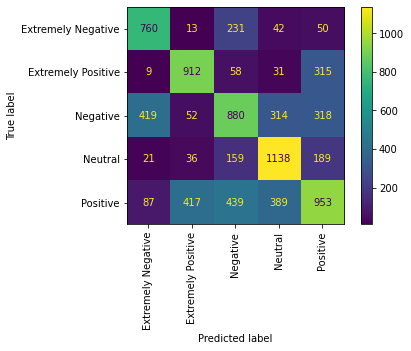

In [80]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)

print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )

print('classification_report','\n')
print(classification_report(sgd_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(sgd_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()



# RandomForestClassifier
The Random forest classifier creates a set of decision trees from a randomly selected subset of the training set. It is basically a set of decision trees (DT) from a randomly selected subset of the training set and then It collects the votes from different decision trees to decide the final prediction.

Training accuracy Score    :  0.9995140470766894
Validation accuracy Score :  0.5764091350826045
classification_report 

                    precision    recall  f1-score   support

Extremely Negative       0.42      0.66      0.51       700
Extremely Positive       0.41      0.70      0.51       766
          Negative       0.55      0.52      0.54      2107
           Neutral       0.77      0.64      0.70      1847
          Positive       0.64      0.52      0.57      2812

          accuracy                           0.58      8232
         macro avg       0.56      0.61      0.57      8232
      weighted avg       0.61      0.58      0.58      8232

confusion_matrix 



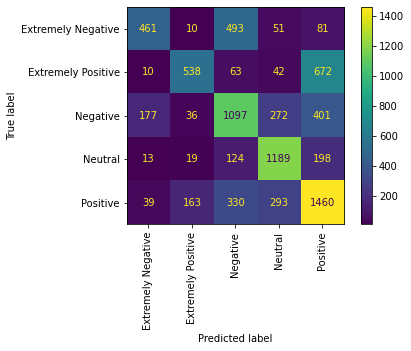

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )

print('classification_report','\n')
print(classification_report(rf_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(rf_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# XGBoost classifier
XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

Training accuracy Score    :  0.4946089597570235
Validation accuracy Score :  0.47351797862001943
classification_report 

                    precision    recall  f1-score   support

Extremely Negative       0.38      0.62      0.47       664
Extremely Positive       0.41      0.66      0.51       818
          Negative       0.40      0.45      0.42      1785
           Neutral       0.56      0.45      0.50      1921
          Positive       0.56      0.42      0.48      3044

          accuracy                           0.47      8232
         macro avg       0.46      0.52      0.48      8232
      weighted avg       0.50      0.47      0.47      8232

confusion_matrix 



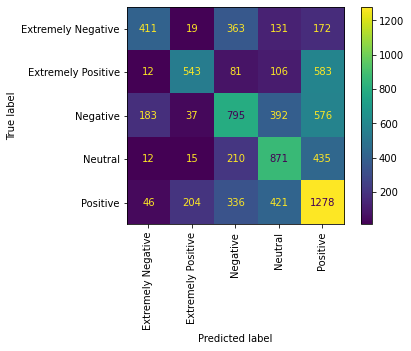

In [ ]:
 #takes huge amount of time to execute
import xgboost as xgb


xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )

print('classification_report','\n')
print(classification_report(xgb_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(xgboost_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# Support vector machine classifier?

A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems. After giving an SVM model sets of labeled training data for each category, they're able to categorize new text

Training accuracy Score    :  0.8969779802581624
Validation accuracy Score :  0.6076287657920311
classification_report 

                    precision    recall  f1-score   support

Extremely Negative       0.50      0.70      0.59       784
Extremely Positive       0.54      0.77      0.64       933
          Negative       0.57      0.55      0.56      2064
           Neutral       0.69      0.65      0.67      1637
          Positive       0.67      0.55      0.60      2814

          accuracy                           0.61      8232
         macro avg       0.60      0.64      0.61      8232
      weighted avg       0.62      0.61      0.61      8232

confusion_matrix 



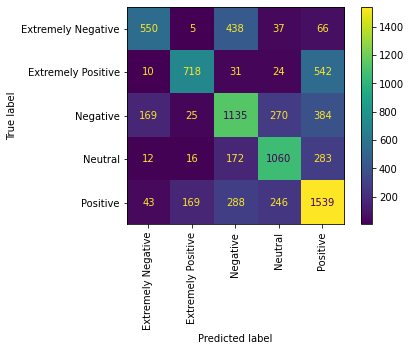

In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )

print('classification_report','\n')
print(classification_report(svc_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(svc,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# CatBoost classifier 
CatBoost is based on gradient boosted decision trees. During training, a set of decision trees is built consecutively. Each successive tree is built with reduced loss compared to the previous trees. The number of trees is controlled by the starting parameters.

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [ ]:
# It takes lots of time to execute
clf2 = CatBoostClassifier()

clf2.fit(X_train, y_train,eval_set=(X_test, y_test), verbose=False)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [ ]:
catboost_prediction = clf2.predict(X_test)
catboost_accuracy = accuracy_score(y_test,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_test))

Training accuracy Score    :  0.6689445709946849
Validation accuracy Score :  0.619290573372206
                    precision    recall  f1-score   support

Extremely Negative       0.54      0.71      0.62       843
Extremely Positive       0.57      0.76      0.65       984
          Negative       0.54      0.58      0.56      1819
           Neutral       0.80      0.60      0.68      2062
          Positive       0.64      0.58      0.61      2524

          accuracy                           0.62      8232
         macro avg       0.62      0.65      0.62      8232
      weighted avg       0.64      0.62      0.62      8232



In [ ]:
models = pd.DataFrame({'Model': ['Support Vector Machines','Random Forest', 'Naive Bayes','Stochastic Gradient Decent', 'XGBoost','CatBoost'],'Test accuracy': [svc_accuracy, rf_accuracy, NB_accuracy, sgd_accuracy, xgb_accuracy,catboost_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
5,CatBoost,0.619291
0,Support Vector Machines,0.607629
1,Random Forest,0.576409
3,Stochastic Gradient Decent,0.564018
2,Naive Bayes,0.487002
4,XGBoost,0.473518


# CONVERTING OUR MULTICLASS CLASSIFICATION INTO BINARY CLASSIFICATION

Let us create binary class as Positive, Extremely Positive, Neutral as (positive) and Negative and Extremely Negative Sentiment as (negative)

In [ ]:
#binary_df = df[['num_char', 'num_words', 'num_sentences','Tweet','Sentiment']]
binary_df = df[['Tweet','Sentiment']]

In [ ]:
# Convert into binary classification problem as positive and negative sentiment
binary_df["Sentiment"]= binary_df["Sentiment"].replace('Positive','Positive') 
binary_df["Sentiment"]= binary_df["Sentiment"].replace('Extremely Positive','Positive') 
binary_df["Sentiment"]= binary_df["Sentiment"].replace('Neutral','Positive') 
binary_df["Sentiment"]= binary_df["Sentiment"].replace('Negative','Negative') 
binary_df["Sentiment"]= binary_df["Sentiment"].replace('Extremely Negative','Negative')

In [ ]:
binary_df.head()

,Tweet,Sentiment
0,,Positive
1,advic talk neighbour famili exchang phone number creat contact list phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med order,Positive
2,coronaviru australia woolworth elderli disabl dedic shop hour amid covid19 outbreak,Positive
3,food stock pleas dont panic there will enough food for everyon need stay calm stay safe covid19fr covid19 covid19 coronaviru confin confinementot confinementgener,Positive
4,me readi supermarket covid19 outbreak not im paranoid food stock litterali the coronaviru thing dont panic caus shortag coronavirusfr restezchezv stayathom confin,Negative


In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split
train,test = train_test_split(binary_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("test shape : ", test.shape)


train shape :  (32925, 2)
test shape :  (8232, 2)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop,max_features=8000)
#vectorizer = CountVectorizer(ngram_range=(1,2),decode_error = 'replace',stop_words = stop,max_features=8000)    #bigram 
#vectorizer = CountVectorizer(ngram_range=(1,3),decode_error = 'replace',stop_words = stop,max_features=8000)    #trigram 


X_train = vectorizer.fit_transform(train.Tweet.values)
X_test = vectorizer.transform(test.Tweet.values)

y_train = train.Sentiment.values
y_test = test.Sentiment.values

In [ ]:
binary_df['Sentiment'].value_counts()

Positive    25759
Negative    15398
Name: Sentiment, dtype: int64

In [ ]:
X_train

<32925x8000 sparse matrix of type '<class 'numpy.int64'>'
	with 474806 stored elements in Compressed Sparse Row format>

# Binary Multinominal Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

training accuracy Score    :  0.8276385725132878
Validation accuracy Score :  0.7886297376093294
              precision    recall  f1-score   support

    Negative       0.71      0.72      0.72      3041
    Positive       0.83      0.83      0.83      5191

    accuracy                           0.79      8232
   macro avg       0.77      0.77      0.77      8232
weighted avg       0.79      0.79      0.79      8232

confusion_matrix 



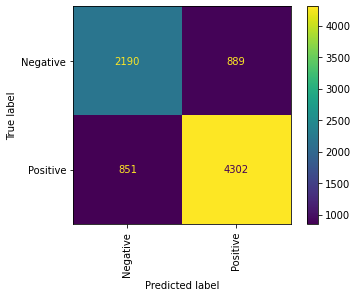

In [ ]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))
print('confusion_matrix','\n')
plot_confusion_matrix(naiveByes_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()


# Binary Stochastic Gradient Descent (SGD) Classifier

Training accuracy Score    :  0.9161123766135155
Validation accuracy Score :  0.8634596695821186
classification_report 

              precision    recall  f1-score   support

    Negative       0.79      0.84      0.81      2883
    Positive       0.91      0.88      0.89      5349

    accuracy                           0.86      8232
   macro avg       0.85      0.86      0.85      8232
weighted avg       0.87      0.86      0.86      8232

confusion_matrix 



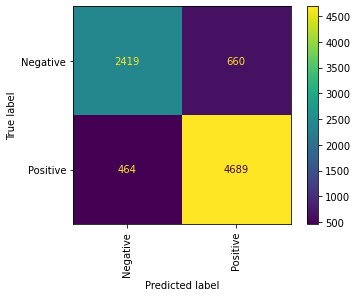

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)

print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )

print('classification_report','\n')
print(classification_report(sgd_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(sgd_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()


# Binary Random Forest Classifier

Training accuracy Score    :  0.9996962794229309
Validation accuracy Score :  0.8364917395529641
classification_report 

              precision    recall  f1-score   support

    Negative       0.74      0.80      0.77      2843
    Positive       0.89      0.85      0.87      5389

    accuracy                           0.84      8232
   macro avg       0.82      0.83      0.82      8232
weighted avg       0.84      0.84      0.84      8232

confusion_matrix 



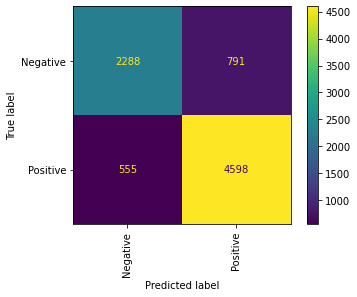

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )

print('classification_report','\n')
print(classification_report(rf_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(rf_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# Binary XgBoost Classifier

Training accuracy Score    :  0.7463629460895975
Validation accuracy Score :  0.7468415937803693
classification_report 

              precision    recall  f1-score   support

    Negative       0.39      0.85      0.54      1431
    Positive       0.96      0.73      0.83      6801

    accuracy                           0.75      8232
   macro avg       0.68      0.79      0.68      8232
weighted avg       0.86      0.75      0.78      8232

confusion_matrix 



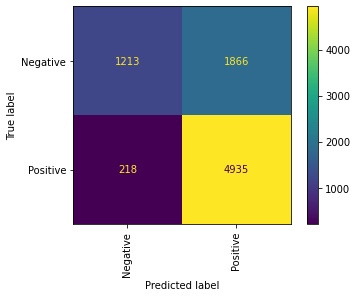

In [ ]:
 #takes huge amount of time to execute
import xgboost as xgb


xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )

print('classification_report','\n')
print(classification_report(xgb_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(xgboost_clf,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# Binary Support Vector Classification

Training accuracy Score    :  0.9541989369779803
Validation accuracy Score :  0.8447521865889213
classification_report 

              precision    recall  f1-score   support

    Negative       0.70      0.86      0.77      2491
    Positive       0.93      0.84      0.88      5741

    accuracy                           0.84      8232
   macro avg       0.82      0.85      0.83      8232
weighted avg       0.86      0.84      0.85      8232

confusion_matrix 



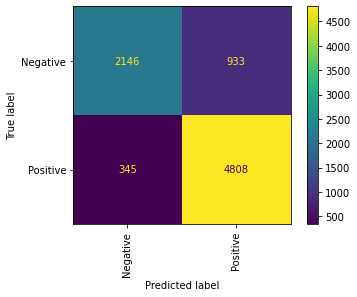

In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )

print('classification_report','\n')
print(classification_report(svc_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(svc,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# Binary CatBoost Classifier

In [ ]:
clf2 = CatBoostClassifier()

clf2.fit(X_train, y_train,eval_set=(X_test, y_test), verbose=False)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [ ]:
catboost_prediction = clf2.predict(X_test)
catboost_accuracy = accuracy_score(y_test,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_test))

Training accuracy Score    :  0.8816400911161731
Validation accuracy Score :  0.8519193391642371
              precision    recall  f1-score   support

    Negative       0.71      0.87      0.78      2540
    Positive       0.93      0.85      0.89      5692

    accuracy                           0.85      8232
   macro avg       0.82      0.86      0.84      8232
weighted avg       0.87      0.85      0.86      8232



# Extra Tree Classifier

Training accuracy Score    :  0.9997266514806378
Validation accuracy Score :  0.8510689990281827
classification_report 

              precision    recall  f1-score   support

    Negative       0.80      0.80      0.80      3047
    Positive       0.88      0.88      0.88      5185

    accuracy                           0.85      8232
   macro avg       0.84      0.84      0.84      8232
weighted avg       0.85      0.85      0.85      8232

confusion_matrix 



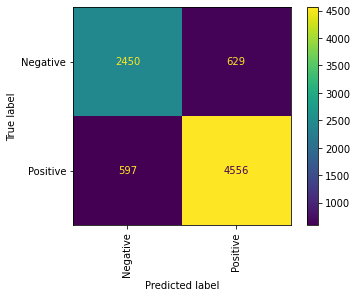

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree = ExtraTreesClassifier()

extra_tree.fit(X_train, y_train)

extra_tree_prediction = extra_tree.predict(X_test)
extra_tree_accuracy = accuracy_score(y_test,extra_tree_prediction)
print("Training accuracy Score    : ",extra_tree.score(X_train,y_train))
print("Validation accuracy Score : ",extra_tree_accuracy )

print('classification_report','\n')
print(classification_report(extra_tree_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(extra_tree,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# Voting Classifier

A voting classifier is a machine learning estimator that trains various base models or estimators and predicts on the basis of aggregating the findings of each base estimator. The aggregating criteria can be combined decision of voting for each estimator output.

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
voting = VotingClassifier(estimators=[('sgd', sgd_clf), ('catboost', clf2), ('extra_tree', extra_tree)],voting='hard')

In [ ]:
voting.fit(X_train,y_train)

Learning rate set to 0.045805
0:	learn: 0.6855192	total: 71.3ms	remaining: 1m 11s
1:	learn: 0.6783189	total: 133ms	remaining: 1m 6s
2:	learn: 0.6712510	total: 211ms	remaining: 1m 10s
3:	learn: 0.6648403	total: 282ms	remaining: 1m 10s
4:	learn: 0.6599585	total: 344ms	remaining: 1m 8s
5:	learn: 0.6550921	total: 406ms	remaining: 1m 7s
6:	learn: 0.6500562	total: 474ms	remaining: 1m 7s
7:	learn: 0.6455657	total: 543ms	remaining: 1m 7s
8:	learn: 0.6410395	total: 606ms	remaining: 1m 6s
9:	learn: 0.6370572	total: 668ms	remaining: 1m 6s
10:	learn: 0.6331955	total: 734ms	remaining: 1m 5s
11:	learn: 0.6294950	total: 801ms	remaining: 1m 5s
12:	learn: 0.6262557	total: 866ms	remaining: 1m 5s
13:	learn: 0.6233134	total: 930ms	remaining: 1m 5s
14:	learn: 0.6200076	total: 996ms	remaining: 1m 5s
15:	learn: 0.6175144	total: 1.07s	remaining: 1m 5s
16:	learn: 0.6147889	total: 1.13s	remaining: 1m 5s
17:	learn: 0.6123165	total: 1.2s	remaining: 1m 5s
18:	learn: 0.6099725	total: 1.26s	remaining: 1m 5s
19:	lear

VotingClassifier(estimators=[('sgd', SGDClassifier(random_state=0)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7f99ce15e790>),
                             ('extra_tree', ExtraTreesClassifier())])

Training accuracy Score    :  0.9354290053151101
Validation accuracy Score :  0.8646744412050534
classification_report 

              precision    recall  f1-score   support

    Negative       0.76      0.86      0.81      2729
    Positive       0.93      0.87      0.90      5503

    accuracy                           0.86      8232
   macro avg       0.84      0.86      0.85      8232
weighted avg       0.87      0.86      0.87      8232

confusion_matrix 



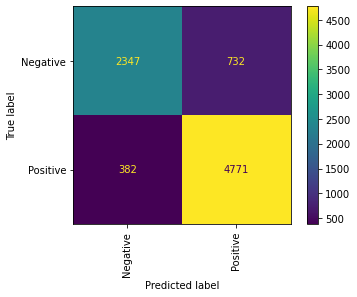

In [ ]:
voting_prediction = voting.predict(X_test)
voting_accuracy = accuracy_score(y_test,voting_prediction)
print("Training accuracy Score    : ",voting.score(X_train,y_train))
print("Validation accuracy Score : ",voting_accuracy )

print('classification_report','\n')
print(classification_report(voting_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(voting,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# Stacking Classifier Algorithms

Stacking is a way of ensembling classification or regression models it consists of two-layer estimators. The first layer consists of all the baseline models that are used to predict the outputs on the test datasets

In [ ]:
# Applying stacking
estimators=[('sgd', sgd_clf), ('catboost', clf2), ('extra_tree', extra_tree)]
final_estimator=RandomForestClassifier()

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
stacking= StackingClassifier(estimators=estimators, final_estimator=final_estimator)

Streaming output truncated to the last 5000 lines.
19:	learn: 0.6121597	total: 1.55s	remaining: 1m 16s
20:	learn: 0.6101616	total: 1.67s	remaining: 1m 17s
21:	learn: 0.6082505	total: 1.78s	remaining: 1m 19s
22:	learn: 0.6064379	total: 1.89s	remaining: 1m 20s
23:	learn: 0.6047137	total: 1.99s	remaining: 1m 21s
24:	learn: 0.6029758	total: 2.1s	remaining: 1m 21s
25:	learn: 0.6012845	total: 2.22s	remaining: 1m 23s
26:	learn: 0.5996485	total: 2.33s	remaining: 1m 24s
27:	learn: 0.5979438	total: 2.44s	remaining: 1m 24s
28:	learn: 0.5965122	total: 2.54s	remaining: 1m 25s
29:	learn: 0.5951869	total: 2.65s	remaining: 1m 25s
30:	learn: 0.5936856	total: 2.75s	remaining: 1m 25s
31:	learn: 0.5925832	total: 2.85s	remaining: 1m 26s
32:	learn: 0.5913162	total: 2.96s	remaining: 1m 26s
33:	learn: 0.5901680	total: 3.06s	remaining: 1m 27s
34:	learn: 0.5889339	total: 3.17s	remaining: 1m 27s
35:	learn: 0.5878496	total: 3.27s	remaining: 1m 27s
36:	learn: 0.5866025	total: 3.38s	remaining: 1m 28s
37:	learn: 0.5

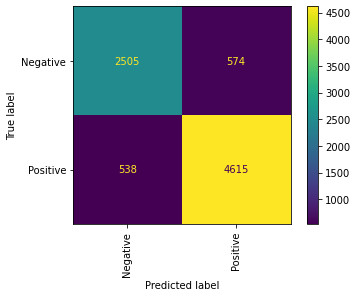

In [ ]:
stacking.fit(X_train,y_train)
stacking_prediction = stacking.predict(X_test)
stacking_accuracy = accuracy_score(y_test,stacking_prediction)
print("Training accuracy Score    : ",stacking.score(X_train,y_train))
print("Validation accuracy Score : ",stacking_accuracy )

print('classification_report','\n')
print(classification_report(stacking_prediction,y_test))

print('confusion_matrix','\n')
plot_confusion_matrix(stacking,X_test,y_test, xticks_rotation='90',cmap='viridis')
plt.show()

# Best Model Evaluation - Stacking Classifier

In [ ]:
# F1 score for our classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(f1_score(y_test,stacking_prediction, average="macro"))

0.8554186450950192


In [ ]:
#score is mean accuracy
scikit_score = sgd_clf.score(X_test,stacking_prediction)
print('scikit score:', scikit_score)

scikit score: 0.9249271137026239


In [ ]:
# Recall score for our winner model
recall_score(y_test, stacking_prediction, average='macro')

0.8545853177283095

In [ ]:
print('classification_report','\n')
print(classification_report(stacking_prediction,y_test))



classification_report 

              precision    recall  f1-score   support

    Negative       0.81      0.82      0.82      3043
    Positive       0.90      0.89      0.89      5189

    accuracy                           0.86      8232
   macro avg       0.85      0.86      0.86      8232
weighted avg       0.87      0.86      0.87      8232



# EVALUATION OF ALL BINARY CLASSIFICATION MODELS

In [ ]:
models = pd.DataFrame({'Model': ['Support Vector Machines','Random Forest', 'Naive Bayes','Stochastic Gradient Decent', 'XGBoost','CatBoost','Extra_tree', 'voting','staking classifier'],'Test accuracy': [svc_accuracy, rf_accuracy, NB_accuracy, sgd_accuracy, xgb_accuracy,catboost_accuracy,extra_tree_accuracy,voting_accuracy, stacking_accuracy]})

sorted_models= models.sort_values(by='Test accuracy', ascending=False)
sorted_models

,Model,Test accuracy
8,staking classifier,0.864917
7,voting,0.864674
3,Stochastic Gradient Decent,0.863460
5,CatBoost,0.851919
6,Extra_tree,0.851069
0,Support Vector Machines,0.844752
1,Random Forest,0.836492
2,Naive Bayes,0.788630
4,XGBoost,0.746842


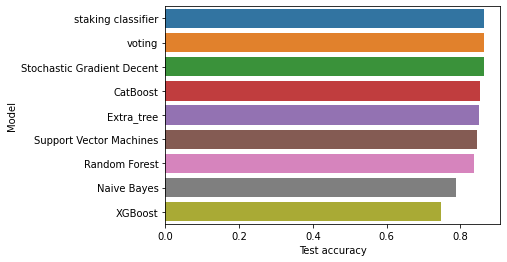

In [ ]:
sns.barplot(data=sorted_models, x='Test accuracy', y='Model')

Stacking Classifier is the best classification model for our problem with 0.86 accuracy score.

# **Conclusion**

1. We have tried Stacking classifier, Stochastic Gradient Decent Classifier, voting, CatBoost, Extre Tree, Support Vector Classiffier, Random Forest Classifier, Multinominal Naive Bayes and XGboost classifier
2. We have Extracted new Features as number of words, charactors and sentenances to check sentiment of the Tweet.We can see that if the number of words, charactors and sentences are more then sentiment of the tweet is more positive. Neutral Sentiment Tweets consists of less numbers of words, charactors and sentences. After evaluating models with these features we have found that these features are not contributing much in the model performance. Hence we have decided to drop them in Binary classification models
3. Firstly we evalute the multi class models as categories -Positive, Extremely Positive, Neutral, Negative, Extremely Negative. We can see, Most of the people (28% ) were having Positive sentiment about covid followed by Negative (24%), Neutral(19%), Extremely Positive (16%) and Extremely Negative(13%).
Our Target variable is not Unbalanceed as all Categories are not having much differences between them.
4. The performance of the Multiclass Models is not satisfactory then we convert the problem into binary class. We have kept only two Sentiments as Positive and Negative.
5. The Binary Stochastic Gradient Decent Classifier has the best performance of accuray 0.86 followed by CatBoost and Extra Tree classifier. 
6. We have checked for Voting classifier and Stacking Classifier with hyperparameter tuning.
7. For vectorizing we have tried all kind of vectorizing methods ie tfidfvectorizer ,countvectorizer, ngrams, after doing hyper parameter tuning, we have decided to use countvectorizer for vectorization.
8. Sentiment Analysis is done based on Positive and Negative Sentiment. 
9. Feature Importance is calculated based on Most Frequent words in each class.
10. We can see London, United States, New York, Washington DC, United Kingdom ,India, Australia, USA are the top locations as far as count of tweets are concerned.
11. We can see that maximum tweets were done at 20 march 2020, when first lockdown was declared. People were more active on Tweeter in the month of March because it was the early stage of Corona virus Pandemics and people wanted to know more about this desease.


# **Challenges Faced**

1. As Data is related to natural language processing sentiment analysis, Time required for data pre processing is high.
2. Feature Extraction and Computation Cost is high.
3. There is a wide scope for Vectorization techniques. 
4. Algorithms like SVC, XGBoost, CatBoost have high computation cost. 
5. Time required to run Stacking and Voting Algorithm more than other algorithms 

# **Scope**

As we are dealing with sentiment analysis of corona virus tweet, Its very important to classify sentiment as either positive or negative to use it as reference for different stakeholders. Government can make use of this information in policymaking as they can able to know how people are reacting to this new strain, what all challenges they are facing such as food scarcity, panic attacks, etc. Various profit organizations can make a profit by analyzing various sentiments as one of the tweets telling us about the scarcity of masks and toilet papers. These organizations can able to start the production of essential items thereby can make profits. Various NGOs can decide their strategy of how to rehabilitate people by using pertinent facts and information.We could do the analysis with three classes as positive, negative and neutral.

Author- Pankaj R. Beldar

Email id- pankajrbell@gmail.com
